## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint
from unet import unet
from utils.datasets_utils import load_dataset, resize_images

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
DATASET_PATH = '../datasets/icoseg/dev_subset'
CHECKPOINTS_PATH = './checkpoints'

In [5]:
!rm -rf $CHECKPOINTS_PATH
!mkdir $CHECKPOINTS_PATH

## 2. Load the dataset

In [6]:
dataset = load_dataset(DATASET_PATH)
images, masks = dataset

images = resize_images(images, new_h=256, new_w=256, ch=3)
masks = resize_images(masks, new_h=256, new_w=256, ch=1)

print(images.shape)
print(masks.shape)

(19, 256, 256, 3)
(19, 256, 256, 1)


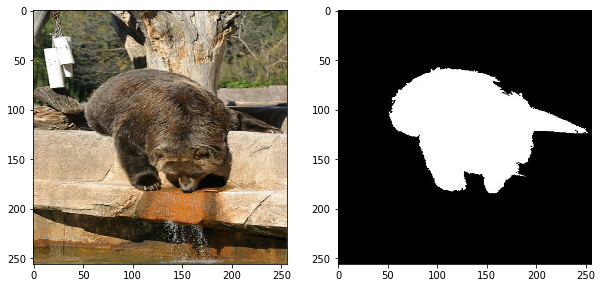

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[15])
plt.subplot(1, 2, 2)
plt.imshow(masks[15].squeeze(), cmap='gray')
plt.show()

## 3. Split the dataset (train/test)

In [8]:
train_images = images[:15]
train_masks = masks[:15]

test_images = images[15:]
test_masks = masks[15:]

## 4. Instantiate a U-Net

In [9]:
model = unet()

## 5. Train the model

In [10]:
model_checkpoint = ModelCheckpoint(f'{CHECKPOINTS_PATH}/unet_icoseg_test.hdf5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True)

model.fit(train_images, train_masks,
          batch_size=5, epochs=10,
          callbacks=[model_checkpoint])

Epoch 1/10
15/15 [==============================] - 13s 868ms/step - loss: 0.6590 - acc: 0.5646

Epoch 00001: loss improved from inf to 0.65900, saving model to ./checkpoints/unet_icoseg_test.hdf5
Epoch 2/10
15/15 [==============================] - 4s 236ms/step - loss: 0.6464 - acc: 0.7429

Epoch 00002: loss improved from 0.65900 to 0.64642, saving model to ./checkpoints/unet_icoseg_test.hdf5
Epoch 3/10
15/15 [==============================] - 3s 226ms/step - loss: 0.4685 - acc: 0.7464

Epoch 00003: loss improved from 0.64642 to 0.46850, saving model to ./checkpoints/unet_icoseg_test.hdf5
Epoch 4/10
15/15 [==============================] - 3s 226ms/step - loss: 0.4401 - acc: 0.7501

Epoch 00004: loss improved from 0.46850 to 0.44013, saving model to ./checkpoints/unet_icoseg_test.hdf5
Epoch 5/10
15/15 [==============================] - 3s 226ms/step - loss: 0.4133 - acc: 0.7576

Epoch 00005: loss improved from 0.44013 to 0.41334, saving model to ./checkpoints/unet_icoseg_test.hdf5
Epo

## 6. Make some predictions with the model

In [19]:
test_preds = model.predict(test_images)
train_preds = model.predict(train_images)

In [20]:
def plot_image_mask_prediction(images, masks, preds, dataset_split=''):
    print(f'dataset_split: {dataset_split}')
    for idx in range(len(preds)):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title(f'initial image ({dataset_split})')
        plt.axis('off')
        plt.imshow(images[idx])
        plt.subplot(1, 3, 2)
        plt.title('ground truth')
        plt.axis('off')
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title('prediction')
        plt.axis('off')
        plt.imshow(preds[idx].squeeze(), cmap='gray')
        plt.show()

dataset_split: test


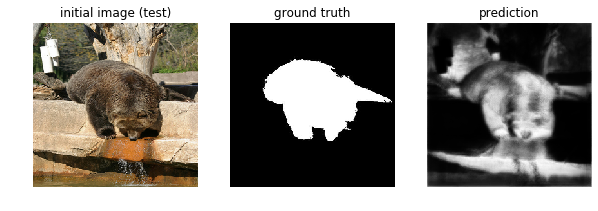

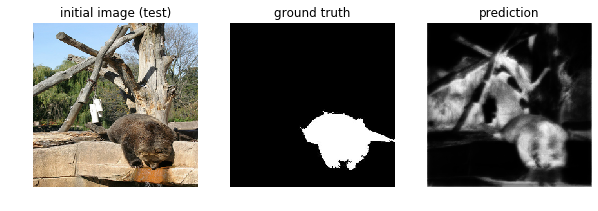

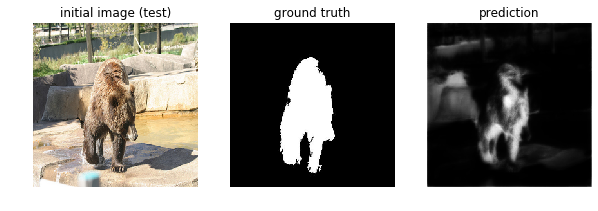

dataset_split: train


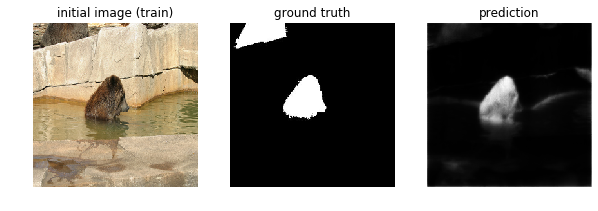

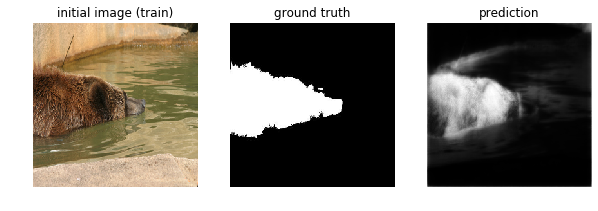

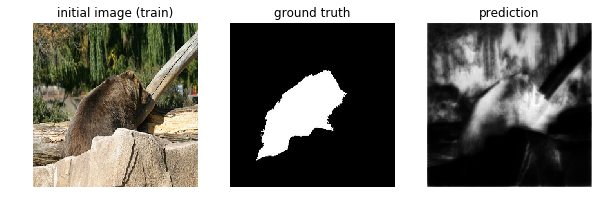

In [22]:
plot_image_mask_prediction(test_images[:3], test_masks[:3], test_preds[:3], dataset_split='test')
plot_image_mask_prediction(train_images[:3], train_masks[:3], train_preds[:3], dataset_split='train')